y Länge: 407, Start: 1991-02-01 00:00:00, Ende: 2024-12-01 00:00:00

Performance:
                  MAE       MSE      RMSE
Mean        1.287757  3.927562  1.981808
RandomWalk  1.948221  8.049108  2.837095
AR1         1.266623  4.168668  2.041732


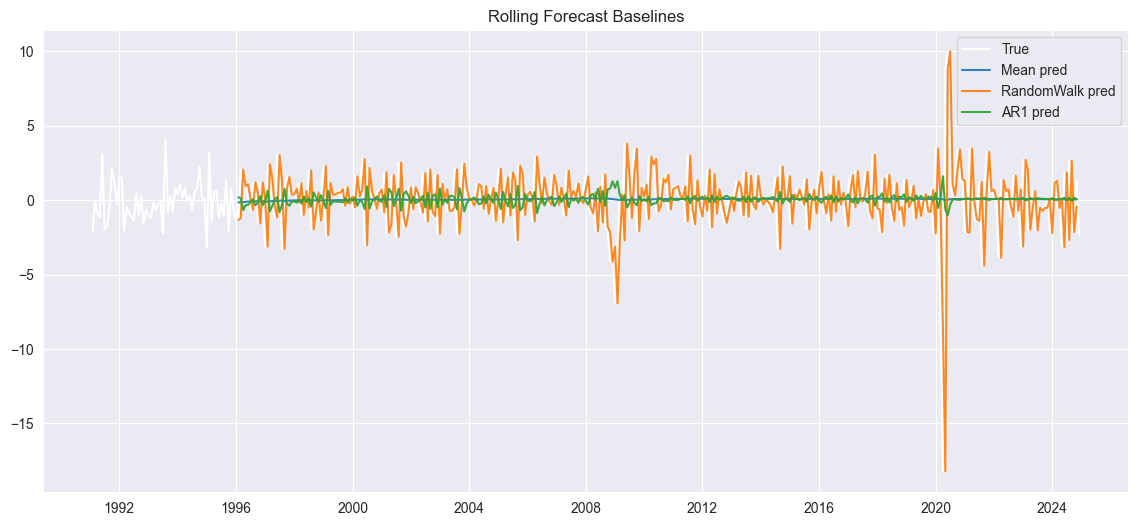

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from models.baseline_models import MeanModel, RandomWalkModel, AR1Model

# --------------------------
# Daten laden
# --------------------------
target = pd.read_csv("../data/processed/target.csv", parse_dates=["date"], index_col="date")
y = target["IP_change"].dropna()
print(f"y Länge: {len(y)}, Start: {y.index.min()}, Ende: {y.index.max()}")

# --------------------------
# Modelle definieren
# --------------------------
models = {
    "Mean": MeanModel(),
    "RandomWalk": RandomWalkModel(),
    "AR1": AR1Model()
}

# --------------------------
# Rolling Forecast (expanding window, horizon=1)
# --------------------------
horizon = 1
preds_all = {}

for name, model in models.items():
    preds = []
    test_idx = []
    for t in range(60, len(y) - horizon):  # min. 5 Jahre Daten
        train = y.iloc[:t].dropna()
        test_val = y.iloc[t:t+horizon]
        if train.empty or test_val.isna().all():
            continue
        model.fit(train)
        pred_val = model.predict(horizon)
        preds.extend(pred_val)
        test_idx.extend(test_val.index)
    preds_all[name] = pd.Series(preds, index=pd.Index(test_idx, name="date")).dropna()

# --------------------------
# Evaluation
# --------------------------
results = {}
for name, series in preds_all.items():
    aligned = y.loc[series.index].dropna()
    series = series.loc[aligned.index]
    errors = aligned - series
    mae = errors.abs().mean()
    mse = (errors**2).mean()
    rmse = np.sqrt(mse)
    results[name] = {"MAE": mae, "MSE": mse, "RMSE": rmse}

results_df = pd.DataFrame(results).T
print("\nPerformance:\n", results_df)

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(14,6))
plt.plot(y.index, y.values, label="True", color="white", linewidth=1.5)
for name, series in preds_all.items():
    plt.plot(series.index, series.values, label=f"{name} pred", alpha=0.9)
plt.title("Rolling Forecast Baselines")
plt.legend()
plt.show()



Performance Ridge:
MAE:  1.6473
MSE:  10.8178
RMSE: 3.2890


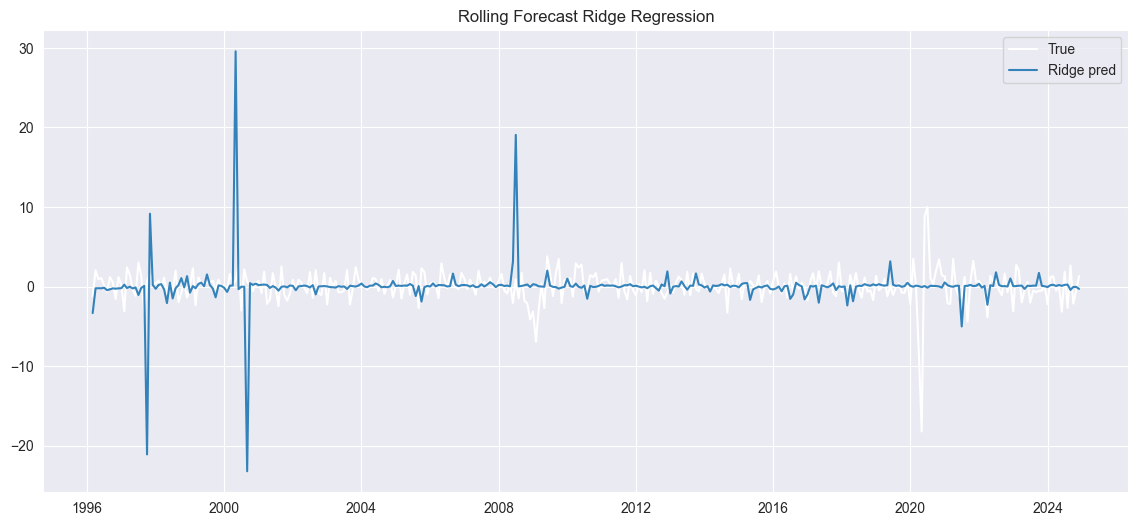

In [3]:
from src.data.preprocess import load_features, expanding_window_splits
from sklearn.linear_model import Ridge

X, y = load_features(diff_type="pct")

model = Ridge(alpha=10.0)
preds, actuals = [], []

for X_train, y_train, X_test, y_test in expanding_window_splits(X, y, min_train_size=60):
    model.fit(X_train, y_train)
    preds.extend(model.predict(X_test))
    actuals.extend(y_test.values)
import numpy as np
import matplotlib.pyplot as plt

# --------------------------
# Evaluation
# --------------------------
errors = np.array(actuals) - np.array(preds)
mae = np.mean(np.abs(errors))
mse = np.mean(errors**2)
rmse = np.sqrt(mse)

print("\nPerformance Ridge:")
print(f"MAE:  {mae:.4f}")
print(f"MSE:  {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

# --------------------------
# Plot
# --------------------------
plt.figure(figsize=(14,6))
plt.plot(y.index[-len(actuals):], actuals, label="True", color="white", linewidth=1.5)
plt.plot(y.index[-len(preds):], preds, label="Ridge pred", alpha=0.9)
plt.title("Rolling Forecast Ridge Regression")
plt.legend()
plt.show()
